In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
#from specutils.fitting import find_lines_threshold, find_lines_derivative
#from scipy.optimize import curve_fit
#from astropy.stats import sigma_clip
from glob import glob
from scipy.signal import find_peaks
from specutils.manipulation import LinearInterpolatedResampler

# Load in data (downloaded in scratch.ipynb using MAST archive API)

In [27]:
spectrum_files = glob(os.path.join('HST','anonymous37222', '*.fits'))

In [193]:
# Load in RU Lupi data
#spectrum_files = glob(os.path.join('HST','mastDownload','HST','*','*x1dsum.fits'))

In [194]:
#spectrum_files = glob(os.path.join('HST','anonymous37141',"*cspec.fits"))

In [47]:
spectrum_header_0 = [fits.getheader(file, ext=0) for file in spectrum_files]
spectrum_header_1 = [fits.getheader(file, ext=1) for file in spectrum_files]
spectrum_x1d = [Table.read(file, hdu=1) for file in spectrum_files]

In [48]:
spectrum_header_0[0]

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NEXTEND =                    1 / Number of standard extensions                  
DATE    = '2025-03-10'         / date this file was written (yyyy-mm-dd)        
FILENAME= 'lbgj02040_x1dsum.fits' / name of file                                
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'COS   '             / identifier for instrument used to acquire data 
EQUINOX =               2000.0 / equinox of celestial coord. system             
                            

In [50]:
#date = [header['DATE-OBS'] for header in spectrum_header]
#observing_run = [header['ROOTNAME'] for header in spectrum_header]
instrument = [header['INSTRUME'] for header in spectrum_header_0]
#instrument_filter = [header['OPT_ELEM'] for header in spectrum_header_0]

In [ ]:
#from each spectrum, function to get specific lines OR specific transitions from France emission_lines.csv

lines = pd.read_csv('HST/emission_lines.csv', skiprows=2)
#lab_emission_lines = lines['lab_lambda']
#transition_grouped_lines = lines.groupby("[nu', J']")

In [ ]:
spectrum_x1d[0]

WAVELENGTH,FLUX,ERROR,SNR,EFF_EXPTIME
Angstrom,erg / (Angstrom s cm2),erg / (Angstrom s cm2),,s
float32[59914],float32[59914],float32[59914],float32[59914],float32[59914]
1135.6062 .. 1795.7308,-9.243304e-17 .. 3.5043925e-14,8.496804e-16 .. 9.7835134e-15,-0.10878565 .. 3.5819366,1199.168 .. 1382.176


In [ ]:
file_idx = 5
flux_units = (u.erg/(u.AA*u.s*(u.cm**-2)))

x1d_wavelength = np.ravel(spectrum_x1d[file_idx]['WAVELENGTH'])
#wavesort_idx = np.argsort(x1d_wavelength)
#x1d_wavelength = x1d_wavelength[wavesort_idx]

x1d_flux = np.ravel(spectrum_x1d[file_idx]['FLUX'])
x1d_fluxerr = np.ravel(spectrum_x1d[file_idx]['ERROR'])

#x1d_flux = x1d_flux[wavesort_idx]
#x1d_fluxerr = x1d_fluxerr[wavesort_idx]

In [ ]:
# spectrum = Spectrum1D(flux = x1d_flux, spectral_axis=x1d_wavelength)
# x1d_lines = find_lines_derivative(spectrum) #noise_factor is the threshold (x*flux error)
# x1d_emissions = x1d_lines[x1d_lines['line_type']=='emission']

In [ ]:
peaks , _ = find_peaks(np.array(x1d_flux), height=max(x1d_fluxerr.value)*2, distance=100)

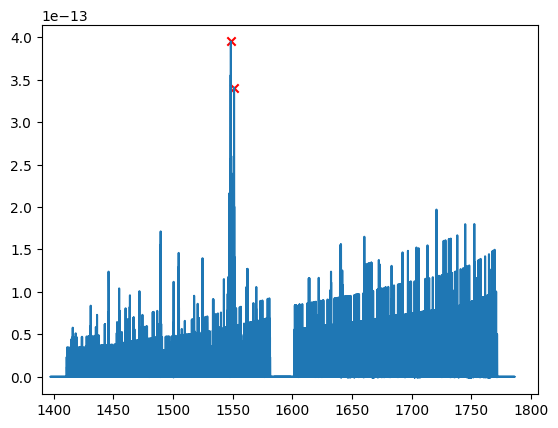

In [ ]:
plt.plot(x1d_wavelength,x1d_flux)
plt.scatter(x1d_wavelength[peaks], x1d_flux[peaks], c='red', marker='x')
plt.xlim(left=1390)
plt.show()

In [ ]:
#Find the emission lines associated with H2 fluorescence
emission_table_idx = []
lab_line_row = []
for i, l in enumerate(lines['lab_lambda']):
    diff = abs(x1d_wavelength[peaks]/u.AA-l)
    if min(diff) < 5:
        emission_table_idx.append(np.argmin(diff))
        lab_line_row.append(lines.iloc[i])

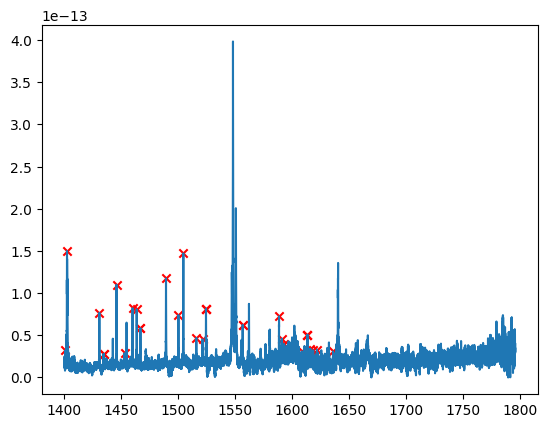

In [ ]:
plt.scatter(np.array(x1d_wavelength[peaks])[emission_table_idx], np.array(x1d_flux[peaks])[emission_table_idx], c='r', marker='x')
plt.plot(x1d_wavelength,x1d_flux)
#plt.xlim(left=1380)
plt.show()

In [ ]:
line_width = 150
x1d_h2_emissions_idx = np.array(peaks)[emission_table_idx]
x1d_h2_emissions_flux = [x1d_flux[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_fluxerr = [x1d_fluxerr[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_wavelength = [x1d_wavelength[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]

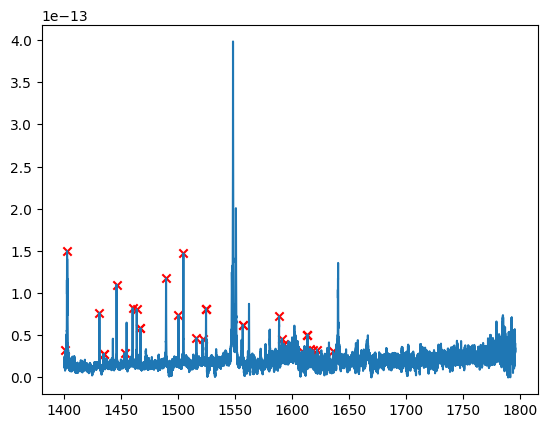

In [ ]:
plt.scatter(np.array(x1d_wavelength)[x1d_h2_emissions_idx], np.array(x1d_flux)[x1d_h2_emissions_idx], c='r', marker='x')
plt.plot(x1d_wavelength, x1d_flux)
plt.xlim(left=1380)
plt.show()

In [ ]:
colnames = ['Line ID', "[nu', J']", "lab_lambda", "spec_flux", "spec_fluxerr", "spec_wavelength"]

line_ID = np.array(lab_line_row)[:, 0]
nu_J = np.array(lab_line_row)[:, 1]
lab_lambda = np.array(lab_line_row)[:, 2]

# Ensure all are 1D numpy arrays or lists of same length
line_ID = np.asarray(line_ID)
nu_J = np.asarray(nu_J)
lab_lambda = np.asarray(lab_lambda)
flux = x1d_h2_emissions_flux
fluxerr = x1d_h2_emissions_fluxerr
wavelength = x1d_h2_emissions_wavelength

# Combine row-wise
data = list(zip(line_ID, nu_J, lab_lambda, flux, fluxerr, wavelength))
spectrum_df = pd.DataFrame(data, columns=colnames)

In [ ]:
spectrum_df.index = spectrum_df["[nu', J']"]
spectrum_df

,Line ID,"[nu', J']",lab_lambda,spec_flux,spec_fluxerr,spec_wavelength
"[nu', J']",,,,,,
"[3,13]",(3–9)P(14),"[3,13]",1608.33,[1.7703417196286188e-14 cm2 erg / (Angstrom s)...,[3.3116178205840627e-15 cm2 erg / (Angstrom s)...,"[1606.56494140625 Angstrom, 1606.5772705078125..."
"[3,13]",(3–10)R(12),"[3,13]",1615.43,"[2.078932254752537e-14 cm2 erg / (Angstrom s),...",[2.9581416543324234e-15 cm2 erg / (Angstrom s)...,"[1614.133056640625 Angstrom, 1614.145385742187..."
"[4,13]",(4–11)R(12),"[4,13]",1613.99,"[5.487166676706925e-15 cm2 erg / (Angstrom s),...",[1.8634191208837837e-15 cm2 erg / (Angstrom s)...,"[1611.4757080078125 Angstrom, 1611.48791503906..."
"[3,16]",(3–7)R(15),"[3,16]",1513.99,[1.9793437112318284e-14 cm2 erg / (Angstrom s)...,[1.8945835805956376e-15 cm2 erg / (Angstrom s)...,"[1513.959716796875 Angstrom, 1513.972045898437..."
"[3,16]",(3–9)R(15),"[3,16]",1593.26,"[3.643838838518834e-14 cm2 erg / (Angstrom s),...","[3.618663240557247e-15 cm2 erg / (Angstrom s),...","[1591.036865234375 Angstrom, 1591.049194335937..."
"[3,16]",(3–10)R(15),"[3,16]",1621.12,[1.8693229405261462e-14 cm2 erg / (Angstrom s)...,[2.8322530766126475e-15 cm2 erg / (Angstrom s)...,"[1619.9132080078125 Angstrom, 1619.92553710937..."
"[4,4]",(4–9)P(5),"[4,4]",1526.55,[2.3042643639524518e-14 cm2 erg / (Angstrom s)...,"[2.075113618468078e-15 cm2 erg / (Angstrom s),...","[1522.4462890625 Angstrom, 1522.4586181640625 ..."
"[4,4]",(4–11)P(5),"[4,4]",1613.72,"[5.487166676706925e-15 cm2 erg / (Angstrom s),...",[1.8634191208837837e-15 cm2 erg / (Angstrom s)...,"[1611.4757080078125 Angstrom, 1611.48791503906..."
"[1,7]",(1–6)P(8),"[1,7]",1467.08,[2.2690731943126458e-14 cm2 erg / (Angstrom s)...,[1.8396350709995934e-15 cm2 erg / (Angstrom s)...,"[1464.8773193359375 Angstrom, 1464.88952636718..."


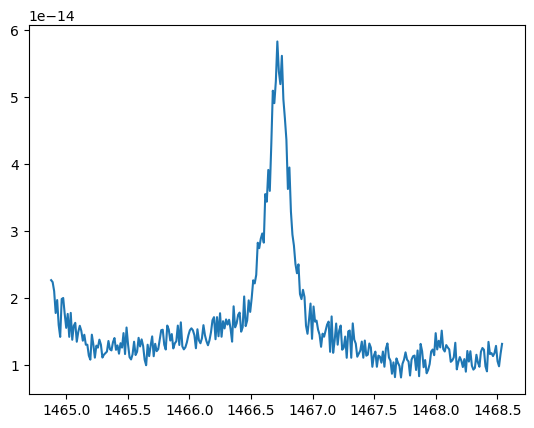

In [ ]:
transition='[0,3]'
plt.plot(np.hstack(spectrum_df['spec_wavelength'][transition]), np.hstack(spectrum_df['spec_flux'][transition]))

# Do this for every file, just keep the line centers though. Making it a function

In [2]:
#import seaborn as sns
#from matplotlib import cycler
import matplotlib as mpl
#clrs = sns.color_palette('Set1')
#clrs[5] = (255/255, 200/255, 80/255)
#colors = cycler('color', list(clrs.as_hex()))
mpl.rc('font', family='serif')
mpl.rc('text', usetex=False)

plt.rc('axes', axisbelow=True, 
       grid=False)#, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
#plt.rcParams['figure.dpi'] = 300

In [65]:
#Keep units for future math
class spectrum():
    def __init__(self, files):
        """
        Initialize spectrum, unpack spectra into useable arrays
        
        Parameters:
        - files: a list of .fits files from HST, each with a header hdu, and a spectrum BinTable hdu
        """
        self.flux_units = (u.erg/(u.AA*u.s*(u.cm**2)))
        self.wavelength_units = u.AA
        self.linelist = None
        #construct dataframe with filename, relevant header information, and spectrum information for each file.
        #Then add to a list of dataframes from files
        rows = []
        for file in files:
            #Use np.ravel here because the wavelength in the table  is a list in one table cell (e.g. [[1, 2, 3]])
            INST_head = fits.getheader(file, ext=0)
            SCI_head = fits.getheader(file, ext=1)
            spectrum_x1d = Table.read(file, hdu=1)
            
            self.x1d_wavelength = np.ravel(spectrum_x1d['WAVELENGTH'])/self.wavelength_units
            self.x1d_flux = np.ravel(spectrum_x1d['FLUX'])/self.flux_units
            self.x1d_fluxerr = np.ravel(spectrum_x1d['ERROR'])/self.flux_units
            date = []
            if "cspec" in file:
                date.append(SCI_head['DATE-BEG'][:10])
            elif "x1dsum" in file:
                date.append(SCI_head['DATE-OBS'])
            instrument = INST_head['INSTRUME']
            try:
                instrument_filter = INST_head['OPT_ELEM']
            except KeyError:
                instrument_filter = INST_head['GRATING'] #in cspec header
            df_data = {'filename':file, 
                       'obsdate':date, 
                       'instrument':instrument, 
                       'filter':instrument_filter, 
                       'wavelength':self.x1d_wavelength*self.wavelength_units, 
                       'flux': self.x1d_flux*self.flux_units, 
                       'fluxerr':self.x1d_fluxerr*self.flux_units}
            rows.append(pd.Series(df_data))
        self.spec_df = pd.DataFrame(rows)
        drop_idx = []
        for i in range(len(self.spec_df)-1):
            if len(self.spec_df.iloc[i]['wavelength'])<1:
                drop_idx.append(i)
        self.spec_df.drop(labels=drop_idx, inplace=True)
        self.spec_df.reset_index(drop=True, inplace=True)

    def coaddwave(self, group):
        """
        Co-add spectra using the spectrum1D function.

        Parameters:
        - grouped dataframe (by date and by filter)

        Returns:
        - coadded_spectrum: spectrum dictionary
        """
        resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
        wavelengths = group['wavelength'].values
        fluxes = group['flux'].values
        fluxerrs = group['fluxerr'].values
        base_wave = wavelengths[0]
        spectra = []

        for wave, flux, err in zip(wavelengths, fluxes, fluxerrs):
            wavesort_idx = np.argsort(wave)
            spec = Spectrum1D(spectral_axis=wave[wavesort_idx], flux=flux[wavesort_idx], uncertainty=StdDevUncertainty(err[wavesort_idx]))
            spec_resampled = resampler(spec, np.sort(base_wave))
            spectra.append(spec_resampled)

        coadded = np.sum(spectra)
        coadd_wave = coadded.wavelength
        coadd_flux = coadded.flux
        coadd_err = coadded.uncertainty.quantity.to(self.flux_units)
        spec_dict = {'wavelength': coadd_wave, 'flux':coadd_flux, 'fluxerr': coadd_err}

        return spec_dict
    
    def H2lines_fromspectrum(self, df, linelist):
        """
        Get the H2 line peaks from the spectrum, and add the peaks to the spectrum dataframe

        Parameters:
        - linelist: an array of

        Returns:
        - Line peak indices and the associated transitions added to the original dataframe
        """
        df['H2line_idx'] = None
        df["[nu', J']"] = None
        for i in range(len(df)):
            row = df.iloc[i]
            peaks , _ = find_peaks(np.array(row['flux'].value), height=max(np.array(row['fluxerr'].value))*2, distance=100)
            
            #Find the emission lines associated with H2 fluorescence
            emission_table_idx = []
            nu_J = []
            if len(peaks)>=1:
                for il, l in enumerate(linelist['lab_lambda']):
                    diff = abs(row['wavelength'][peaks]/u.AA-l)

                    if min(diff) <= 0.5:
                        emission_table_idx.append(np.argmin(diff))
                        nu_J.append(linelist['[nu\', J\']'].iloc[il])
                df.at[i, 'H2line_idx'] = np.array(peaks)[emission_table_idx]
                df.at[i, "[nu', J']"] = nu_J
            else:
                pass
        return df

    #next step is to coadd full spectra and then get line properties

# Initialize spectrum class with HST files
The data is interesting, I don't have older data, and the cspec files are weird.

In [ ]:
x1dsum_files = glob(os.path.join('HST', 'anonymous37222', '*x1dsum.fits'))
cspec_files = glob(os.path.join('HST','anonymous37141',"*cspec.fits"))
spectrum_files = np.hstack([x1dsum_files, cspec_files])
all_spectra = spectrum(x1dsum_files)

In [6]:
linelist = pd.read_csv('HST/emission_lines.csv', skiprows=2)

In [7]:
df = all_spectra.spec_df
all_spectra.H2lines_fromspectrum(df, linelist)

,filename,obsdate,instrument,filter,wavelength,flux,fluxerr,H2line_idx,"[nu', J']"
0,HST/anonymous37222/lbgj02040_x1dsum.fits,2025-03-10,COS,G130M,"[1277.973751578046 Angstrom, 1277.983716119582...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...",12505,"[[0,2]]"
1,HST/anonymous37222/lbgj02050_x1dsum.fits,2025-03-10,COS,G130M,"[1287.6826131868756 Angstrom, 1287.69257923781...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[14380, 11161, 11528, 10759]","[[1,4], [0,1], [0,2], [0,3]]"
2,HST/anonymous37222/lbgj02060_x1dsum.fits,2025-03-10,COS,G130M,"[1297.231549843736 Angstrom, 1297.241517334014...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...",[],[]
3,HST/anonymous37222/lbgj02080_x1dsum.fits,2025-03-10,COS,G160M,"[1574.2079430415886 Angstrom, 1574.22018228647...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[3236, 3236, 25729, 27711, 30345, 20058, 21296...","[[4,13], [4,4], [1,7], [1,7], [1,7], [1,4], [1..."
4,HST/anonymous37222/lbgj02090_x1dsum.fits,2025-03-10,COS,G160M,"[1585.6149893851523 Angstrom, 1585.62723013010...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...",[],[]
...,...,...,...,...,...,...,...,...,...
86,HST/anonymous37222/lephae040_x1dsum.fits,2025-03-11,COS,G160M,"[1609.5802403789269 Angstrom, 1609.59249279291...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...",23190,"[[1,4]]"
87,HST/anonymous37222/leso2c010_x1dsum.fits,2025-03-11,COS,G160M,"[1574.2695000413048 Angstrom, 1574.28174833542...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...",26087,"[[1,4]]"
88,HST/anonymous37222/leso2c020_x1dsum.fits,2025-03-11,COS,G130M,"[1277.3623641485256 Angstrom, 1277.37233281452...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...",[],[]
89,HST/anonymous37222/leso2d010_x1dsum.fits,2025-03-11,COS,G160M,"[1609.6796802860497 Angstrom, 1609.69193345732...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...",[],[]


In [8]:
#coadd per date
res = df.groupby(['obsdate', 'filter']).apply(all_spectra.coaddwave, include_groups=False)

In [9]:
stacked_wave = []
stacked_flux = []
stacked_fluxerr = []
date = np.array(res.index.get_level_values('obsdate'))
filter = np.array(res.index.get_level_values('filter'))
for i in range(len(res.values)):
    stacked_wave.append(res.values[i]['wavelength'])
    stacked_flux.append(res.values[i]['flux'])
    stacked_fluxerr.append(res.values[i]['fluxerr'])
stacked_df = pd.DataFrame({'obsdate':date, 'filter':filter, 'wavelength':stacked_wave, 'flux':stacked_flux, 'fluxerr':stacked_fluxerr})

In [110]:
all_spectra.H2lines_fromspectrum(stacked_df, linelist)

,obsdate,filter,wavelength,flux,fluxerr,H2line_idx,"[nu', J']"
0,2024-10-09,G230L,"[1629.7767989689344 Angstrom, 1630.16885217535...","[5.865623474412629e-14 erg / (Angstrom s cm2),...",[1.3131359388259667e-13 erg / (Angstrom s cm2)...,[],[]
1,2025-03-10,G130M,"[1124.7185766387568 Angstrom, 1124.72853832954...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...",28891,"[[0,2]]"
2,2025-03-10,G160M,"[1386.0412954067515 Angstrom, 1386.05353027634...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[9321, 11299, 13932, 4878, 8429, 9672, 6030, 1...","[[1,7], [1,7], [1,7], [1,4], [1,4], [1,4], [0,..."
3,2025-03-11,G130M,"[1124.122411192166 Angstrom, 1124.132378553306...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...",[],[]
4,2025-03-11,G160M,"[1385.9946471407397 Angstrom, 1386.00688689571...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19198, 19602, 17930, 7429, 11507, 19602, 6616...","[[3,13], [4,13], [3,16], [4,4], [4,4], [4,4], ..."
5,2025-03-13,G130M,"[1135.59619140625 Angstrom, 1135.606201171875 ...","[2.261851560810945e-15 erg / (Angstrom s cm2),...",[1.7358277013442072e-15 erg / (Angstrom s cm2)...,"[29592, 31111, 26379, 26752]","[[1,4], [1,4], [0,1], [0,2]]"
6,2025-03-13,G130M-G160M,"[1135.606201171875 Angstrom, 1135.616088867187...",[-1.8486607893877392e-16 erg / (Angstrom s cm2...,[1.2016295477250441e-15 erg / (Angstrom s cm2)...,"[33046, 35771, 37747, 40378, 29591, 31110, 348...","[[1,7], [1,7], [1,7], [1,7], [1,4], [1,4], [1,..."
7,2025-03-13,G160M,"[1422.6502685546875 Angstrom, 1422.66259765625...",[1.3802584862150073e-13 erg / (Angstrom s cm2)...,[1.4010364548186376e-14 erg / (Angstrom s cm2)...,"[15186, 15732, 7080, 15592, 7442, 13915, 16242...","[[3,13], [3,13], [4,13], [4,13], [3,16], [3,16..."
8,2025-03-13,G160M-G230L,"[1395.537109375 Angstrom, 1395.54931640625 Ang...","[6.61938084418688e-14 erg / (Angstrom s cm2), ...",[1.5930102996183335e-14 erg / (Angstrom s cm2)...,"[17792, 17792, 5828, 8550, 10524, 13155, 2887,...","[[4,13], [4,4], [1,7], [1,7], [1,7], [1,7], [1..."
9,2025-03-13,G230L,"[1401.166748046875 Angstrom, 1401.581787109375...","[4.625822218294759e-09 erg / (Angstrom s cm2),...","[1.20756025965322e-08 erg / (Angstrom s cm2), ...",[],[]


In [26]:
g130m = np.hstack(df[(df['obsdate']=='2025-03-11') & (df['filter']=='G130M')]['wavelength'])
g160m = np.hstack(df[(df['obsdate']=='2025-03-11') & (df['filter']=='G160M')]['wavelength'])
print(min(g130m), max(g130m))
print(min(g160m), max(g160m))

1124.1220811272192 Angstrom 1440.6790191373045 Angstrom
1385.9894779844765 Angstrom 1810.4233852465268 Angstrom


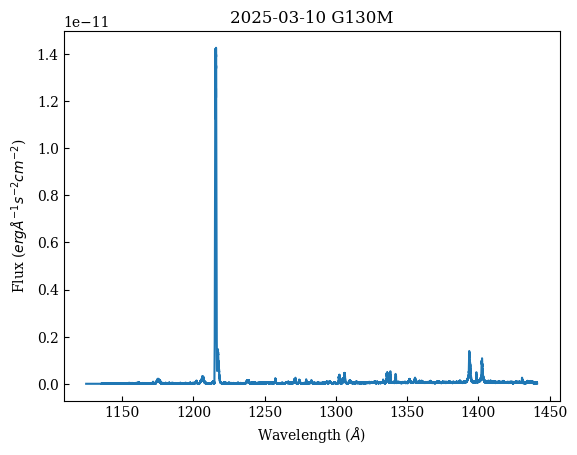

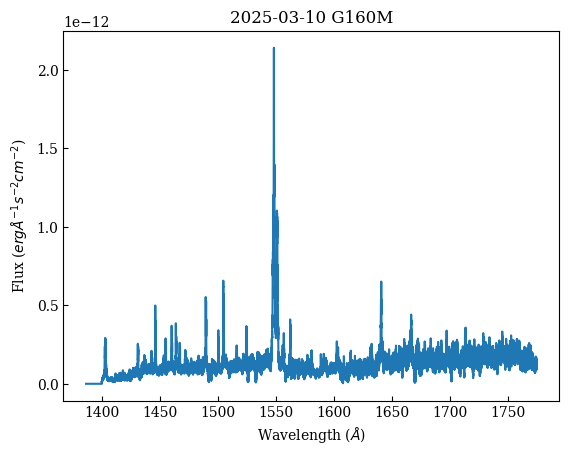

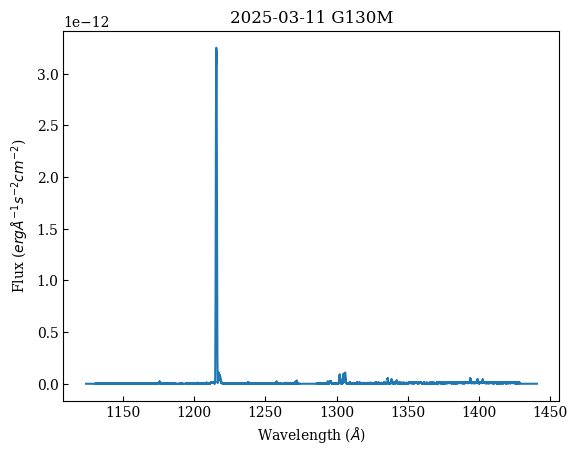

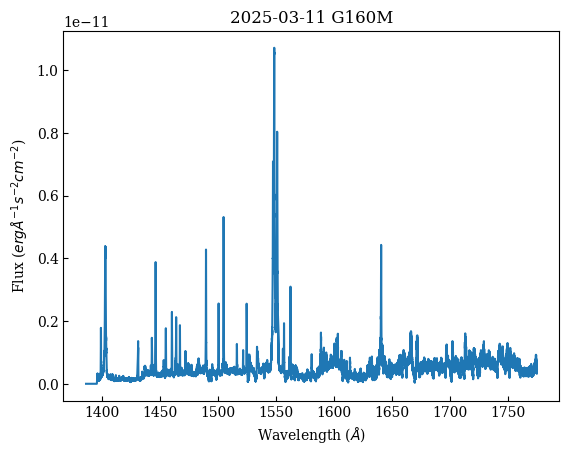

In [37]:
for date, filter in res.keys():
    plt.plot(res[date][filter]['wavelength'], res[date][filter]['flux'])
    plt.title(date+' '+filter)
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel(r'Flux ($erg \AA^{-1} s^{-2} cm^{-2}$)')
    plt.show()